In [1]:
import pandas as pd
import numpy as np
import sys
import os 
import glob
import obspy
import specufex
import h5py
import yaml
from tqdm import trange
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import time
from matplotlib import pyplot as plt 

sys.path.append('../src/')

from f1_spectrogram_functions import wf_to_H5, gen_sgram_QC_noAlias


## change this to input arg
yamlPath = "/Users/theresasawi/Documents/11_Manuscripts/Methods_Paper/data/yaml/demo_50Hz_v3.yaml"


In [2]:


####################################################################################
####################################################################################
###
### Load yaml file settings, creat paths, set parameters
###
####################################################################################
####################################################################################



with open(yamlPath) as stream:
    config = yaml.safe_load(stream)
    
path_config = config["paths"]
key = path_config["key"]
print("Project key:", key)


# build path strings
dataH5_name = f'data_{key}.h5'
projectPath = path_config["projectPath"]
path_waveform = path_config["waveformPath"]
# path_waveform = 

SpecUFEx_H5_name = 'SpecUFEx_' + path_config["h5name"] #f'SpecUFEx_{key}.hdf5'
SpecUFEx_H5_path = projectPath + 'data/H5files/' + SpecUFEx_H5_name


if not os.path.isdir(projectPath + 'data/H5files/'):
    os.mkdir(projectPath + 'data/H5files/')
    

print("waveform folder path in:", path_waveform)
print(len(glob.glob(path_waveform + "*")), "waveforms in folder")

if not os.path.isdir(projectPath + 'data/H5files/'):
    os.mkdir(projectPath + 'data/H5files/')
    
dataH5_path = projectPath + 'data/H5files/' + dataH5_name


##spectrogram parameters, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html


#Spectrogram parameters
sgram_config = config['sgramParams']

decimation_factor = sgram_config['decimation_factor']               
fmin = sgram_config['fmin']               
fmax = sgram_config['fmax']               
winLen_Sec = sgram_config['winLen_Sec']
fracOverlap = sgram_config['fracOverlap']
nfft = sgram_config['nfft']




Project key: demo_50Hz_v3
waveform folder path in: /Users/theresasawi/Documents/12_Projects/specufex_tutorial/data/Geysers_WF/
1820 waveforms in folder


In [3]:
####################################################################################
####################################################################################
###
### Create catalog with event ids made from filenames, load demo wave
###
####################################################################################
####################################################################################

import random

random.seed(42)
wf_list0 = glob.glob(path_waveform + '/*')
wf_list0.sort()

##get 1500 subset
wf_list = random.sample(wf_list0, 1500)


filenames = wf_list
ev_ID = [path.split('/')[-1] for path in wf_list]


print('Example evID: ', ev_ID[0])

cat_paths = pd.DataFrame({"ev_ID":ev_ID,
                          "filename":wf_list})


wf_test = obspy.read(cat_paths.filename.iloc[0])

lenData = len(wf_test[0].data)
fs = wf_test[0].stats.sampling_rate

nperseg = int(sgram_config["winLen_Sec"]*fs) #datapoints per window segment
noverlap = int(nperseg*sgram_config["fracOverlap"])  #fraction of window overlapped  

#padding must be longer than n per window segment
if nfft < nperseg:
    nfft = nperseg*2
    print("nfft too short; changing to ", nfft)

mode='magnitude'
scaling='spectrum'


# set args for generator
args = {'fs': fs,
        'lenData': lenData,
        'nperseg': nperseg,
        'noverlap': noverlap,
        'nfft': nfft,
        'mode': mode,
        'scaling': scaling,
        'fmin': fmin,
        'fmax': fmax
       }


print(args)


Example evID:  SQK.BG.DPZ..D.2014.033.095254
{'fs': 500.0, 'lenData': 10000, 'nperseg': 250, 'noverlap': 62, 'nfft': 2048, 'mode': 'magnitude', 'scaling': 'spectrum', 'fmin': 1, 'fmax': 50}


In [4]:
####################################################################################
#############################dd#######################################################
###
### Save waveforms to H5
###
####################################################################################
####################################################################################


evID_keep, wf_example = wf_to_H5(projectPath,dataH5_path,cat_paths,lenData, verbose=1)

###################################
## Save processing information to data H5
###################################
with h5py.File(dataH5_path,'a') as h5file:
    processing_group = h5file.create_group("processing_info")
    processing_group.create_dataset(name= "sampling_rate_Hz", data=fs)#,dtype='S')
    processing_group.create_dataset(name= "lenData", data=lenData)#,dtype='S')
    

0 / 1500
SQK.BG.DPZ..D.2012.034.073921  not saved
1000 / 1500
SQK.BG.DPZ..D.2014.337.023159  not saved
SQK.BG.DPZ..D.2014.335.223910  not saved
0  duplicate events found and avoided
1497  waveforms loaded


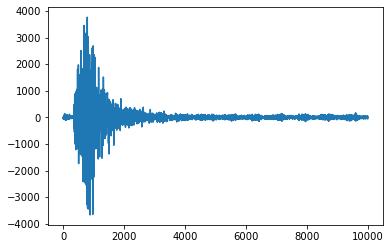

In [5]:
plt.plot(wf_example)

In [6]:


####################################################################################
####################################################################################
###
### Make spectrograms H5, make parameters group in H5
###
####################################################################################
####################################################################################

## Save processing information to spectrogram H5
if os.path.isfile(SpecUFEx_H5_path): ## avoiding this error: ValueError: Unable to create group (name already exists)
        
    os.remove(SpecUFEx_H5_path)
    
    with h5py.File(SpecUFEx_H5_path,'a') as fileLoad:
        
        spec_parameters_group  = fileLoad.create_group(f"spec_parameters")
        
        spec_parameters_group.clear()
    
        spec_parameters_group.create_dataset(name= 'fs', data=fs)
        spec_parameters_group.create_dataset(name= 'lenData', data=lenData)
        spec_parameters_group.create_dataset(name= 'nperseg', data=nperseg)
        spec_parameters_group.create_dataset(name= 'noverlap', data=noverlap)
        spec_parameters_group.create_dataset(name= 'nfft', data=nfft)
        spec_parameters_group.create_dataset(name= 'mode', data=mode)
        spec_parameters_group.create_dataset(name= 'scaling', data=scaling)
        spec_parameters_group.create_dataset(name= 'fmin', data=fmin)
        spec_parameters_group.create_dataset(name= 'fmax', data=fmax)
        
        



# Look-test spectrogram 

In [7]:
####################################################################################
####################################################################################
###
### Instantiate generator and generate spectrograms
###
####################################################################################
####################################################################################

start_time = time.time() # 3.0922142305639055 hours for 45k sgrams



# put sgrams in h5
gen_sgram = gen_sgram_QC_noAlias(decimation_factor=decimation_factor,
                                 key = key,
                                evID_list=evID_keep,
                                dataH5_path = dataH5_path,#h5 data file
                                h5File=SpecUFEx_H5_path, #h5 sgram file
                                saveMat=False, #set true to save folder of .mat files
                                sgramOutfile='.', #path to save .mat files
                                **args
                                ) #path to save sgram figures




# def sgramH5

evID_list_QC_sgram = []
spectra_for_avg = []

less10=0
with h5py.File(SpecUFEx_H5_path,'a') as fileLoad:

    n=0
    Nkept=0

    if 'spectrograms' in fileLoad.keys():
        del fileLoad["spectrograms"]

    if 'sgram_normConst' in fileLoad.keys():
        del fileLoad["sgram_normConst"]

    spectrograms_group     = fileLoad.create_group(f"spectrograms")

    sgram_normConst_group  = fileLoad.create_group(f"sgram_normConst")

    lenEv = len(evID_keep)
    
    while n <= 2: ## not sure a better way to execute this? But it works
        evID,sgram,fSTFT,tSTFT, normConstant, Nkept,evID_BADones, i = next(gen_sgram) #next() command updates generator
        
        n+=1

            
print('done')           

0 / 1497
done


(1950, 200)

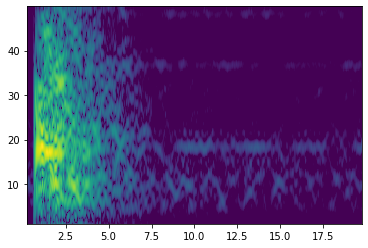

In [8]:
from matplotlib import pyplot as plt

plt.pcolormesh(tSTFT, fSTFT, sgram)
len(tSTFT), len(fSTFT)

In [9]:
####################################################################################
####################################################################################
###
### Instantiate generator and generate spectrograms
###
####################################################################################
####################################################################################

start_time = time.time() # 3.0922142305639055 hours for 45k sgrams



# put sgrams in h5
gen_sgram = gen_sgram_QC_noAlias(decimation_factor=decimation_factor,
                                 key = key,
                                evID_list=evID_keep,
                                dataH5_path = dataH5_path,#h5 data file
                                h5File=SpecUFEx_H5_path, #h5 sgram file
                                saveMat=False, #set true to save folder of .mat files
                                sgramOutfile='.', #path to save .mat files
                                **args
                                ) #path to save sgram figures




# def sgramH5

evID_list_QC_sgram = []
spectra_for_avg = []

less10=0
with h5py.File(SpecUFEx_H5_path,'a') as fileLoad:

    n=0
    Nkept=0

    if 'spectrograms' in fileLoad.keys():
        del fileLoad["spectrograms"]

    if 'sgram_normConst' in fileLoad.keys():
        del fileLoad["sgram_normConst"]

    spectrograms_group     = fileLoad.create_group(f"spectrograms")

    sgram_normConst_group  = fileLoad.create_group(f"sgram_normConst")

    lenEv = len(evID_keep)
    
    while n <= lenEv: ## not sure a better way to execute this? But it works
        try:   #catch generator "stop iteration" error
            evID,sgram,fSTFT,tSTFT, normConstant, Nkept,evID_BADones, i = next(gen_sgram) #next() command updates generator
             
            n = i+1
            evID = str(evID)
            

            if not evID in spectrograms_group:
                

                spectrograms_group.create_dataset(name= evID, data=sgram)
                evID_list_QC_sgram.append(evID)
                spectra_for_avg.append(np.array(sgram))



                if not evID in sgram_normConst_group:

                    sgram_normConst_group.create_dataset(name= evID, data=normConstant)
                    

        except StopIteration: #handle generator error
            break

    print('N events in evID_list_QC_sgram:', len(evID_list_QC_sgram))
    print('N events in evID_BADones:', len(evID_BADones))

    if 'spec_parameters' in fileLoad.keys():
        del fileLoad["spec_parameters"]

        

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")
        
    
# demo_150Hz = 11131.97123003006 / 3600 = 3.0922142305639055    
# demo_50Hz = 1816 waveforms = Elapsed time: 434.92547726631165 seconds
# demo_50Hz = decimate 20, 1816 waveforms = Elapsed time: 415.6481509208679 seconds

0 / 1497
OHHHH we got a ZERO median here!!
1000 / 1497
N events in evID_list_QC_sgram: 1496
N events in evID_BADones: 1
Elapsed time: 357.74387192726135 seconds


In [10]:
####################################################################################
####################################################################################
###
### Save more sgram paramters to H5
###
####################################################################################
####################################################################################


with h5py.File(SpecUFEx_H5_path,'a') as fileLoad:
    try:
        fSTFT_group = fileLoad.create_group(f"fSTFT")
        fSTFT_group.create_dataset(name='fSTFT', data=fSTFT)
    except:
        pass

    try:
        tSTFT_group = fileLoad.create_group(f"tSTFT")
        tSTFT_group.create_dataset(name='tSTFT', data=tSTFT)
    except: 
        pass

In [11]:
import os

os.system("say 'spectrograms complete'")

0